<a href="https://colab.research.google.com/github/baromas/payment-ab-testing/blob/main/ab_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###  1. A/B–тестирование

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm.auto import tqdm
import requests
from urllib.parse import urlencode
%matplotlib inline

In [ ]:
active_studs_pk = 'https://disk.yandex.ru/d/WS_JsuTI91Uzlw'
checks_pk = 'https://disk.yandex.ru/d/Qa5pxehNl-mWyw'
groups_pk = 'https://disk.yandex.ru/d/jk_gCkeu1M1iIw'
groups_add_pk = 'https://disk.yandex.ru/d/l2YecxlwrKj-fQ'

def get_yandex_download_url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

active_studs = pd.read_csv(get_yandex_download_url(active_studs_pk))
checks = pd.read_csv(get_yandex_download_url(checks_pk), sep = ';')
groups = pd.read_csv(get_yandex_download_url(groups_pk), sep = ';')
groups_add = pd.read_csv(get_yandex_download_url(groups_pk), sep = ';')

Посмотрим на входные данные

***Таблица groups***

In [ ]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [ ]:
groups.shape

(74484, 2)

In [ ]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [ ]:
groups.grp.value_counts()

grp
B    59813
A    14671
Name: count, dtype: int64

In [ ]:
groups.id.nunique()

74484

***Таблица groups_add***

In [ ]:
groups_add.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [ ]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [ ]:
groups_add.shape

(74484, 2)

In [ ]:
groups_add.grp.value_counts()

grp
B    59813
A    14671
Name: count, dtype: int64

In [ ]:
groups_add.id.nunique()

74484

***Таблица active_studs***

In [ ]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [ ]:
active_studs.dtypes

student_id    int64
dtype: object

In [ ]:
active_studs.shape

(8341, 1)

In [ ]:
active_studs.nunique()

student_id    8341
dtype: int64

In [ ]:
active_studs.isna().sum()

student_id    0
dtype: int64

***Таблица checks***

In [ ]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [ ]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [ ]:
checks.shape

(541, 2)

In [ ]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [ ]:
checks.student_id.nunique()

541

Соединю дополнительный файл groups_add с groups и посмотрю на распределение пользователей по группам

In [ ]:
groups_all = pd.concat([groups, groups_add])
groups_all

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [ ]:
groups_all.grp.value_counts()

grp
B    119626
A     29342
Name: count, dtype: int64

Таким образом, у нас всего 74576 пользователей и распределение по группам явно неравномерное.\
Проверим все ли пользователи заходили в приложение и совершали оплату, так как посещение сайта является условием для использования новой механики оплаты.

In [ ]:
print('Количество пользователей из списка активных, но не вошедших в общий список:',
     active_studs.query("student_id not in @groups_all.id").shape[0],
     '\nКоличество оплативших пользователей, отсутствующих в общем списке:',
     checks.query("student_id not in @groups_all.id").shape[0],
     '\nКоличество оплативших пользователей, отсутствующих в списке активных в дни проведения теста:',
     checks.query('student_id not in @active_studs.student_id').shape[0])

Количество пользователей из списка активных, но не вошедших в общий список: 13 
Количество оплативших пользователей, отсутствующих в общем списке: 1 
Количество оплативших пользователей, отсутствующих в списке активных в дни проведения теста: 149


Видим, что в период проведения экспериментов были оплаты и от тех студентов (149), которые не посещали платформу. Возможно, это автоматические оплаты или сбой в системе. \
Посмотрим на распределение групп в checks и active_studs:

In [ ]:
groups_all.query("id in @active_studs.student_id").grp.value_counts()

grp
B    13586
A     3070
Name: count, dtype: int64

In [ ]:
groups_all.query("id in @checks.student_id").grp.value_counts()

grp
B    866
A    214
Name: count, dtype: int64

In [ ]:
groups_all.query("id in @active_studs.student_id & id in @checks.student_id").grp.value_counts()

grp
B    626
A    156
Name: count, dtype: int64

#### Промежуточный вывод
* Пользователи распределены по группам неравномерно. Группа B значительно больше, чем группа А.
* У нас 74576 пользователей, из них 8341 являются активными, 541 совершили оплату. Из общего количества совершивших оплату (541), 392 являются активными - оплатившими. Не ясно, это сбой системы или автоматические платежи , поэтому не стану включать этих пользователей в AB-тест.

Я буду проверять гипотезы на активных и совершивших оплату пользователей, так как нецелесообразно проверять гипотезы эксперимента на пользователях, которые были отобраны, но в нем не участвовали
#### Объединим все таблицы в один df и отфильтруем пользователей для AB-теста

In [ ]:
active_checks = active_studs.merge(checks, how = 'left', on = 'student_id')
active_checks.rename(columns = {"student_id" : 'id'}, inplace = True)
active_checks.query("rev.notna()")
active_checks

,id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN
...,...,...
8336,1794344,NaN
8337,296883,NaN
8338,3598448,NaN
8339,3610547,290.0


In [ ]:
active_total = active_checks.merge(groups_all, how = 'left', on = 'id')
active_total['payment'] = active_total.rev.apply(lambda x : 0 if np.isnan(x) else 1)
active_total.rev = active_total.rev.fillna(0)
active_total

,id,rev,grp,payment
0,581585,0.0,A,0
1,581585,0.0,A,0
2,5723133,0.0,NaN,0
3,3276743,0.0,B,0
4,3276743,0.0,B,0
...,...,...,...,...
16664,3598448,0.0,B,0
16665,3610547,290.0,B,1
16666,3610547,290.0,B,1
16667,205705,0.0,B,0


In [ ]:
active_total_paid = active_total.query("rev > 0")
active_total_paid

,id,rev,grp,payment
123,1184303,1530.0000,A,1
124,1184303,1530.0000,A,1
133,3354191,1900.0001,B,1
134,3354191,1900.0001,B,1
153,3278734,1900.0000,B,1
...,...,...,...,...
16514,1516339,290.0000,A,1
16541,3910596,597.0000,B,1
16542,3910596,597.0000,B,1
16665,3610547,290.0000,B,1


<Axes: >

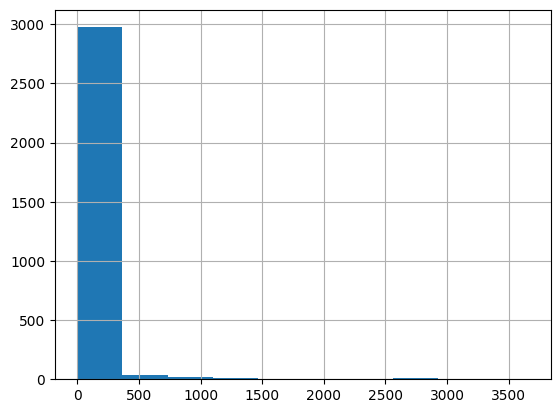

In [ ]:
active_total.query("grp == 'A'").rev.hist()

<Axes: >

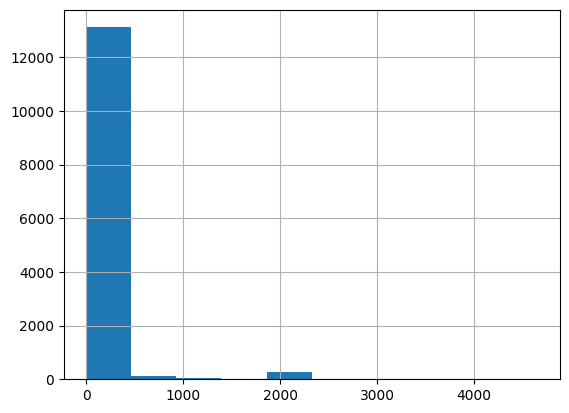

In [ ]:
active_total.query("grp == 'B'").rev.hist()

<Axes: >

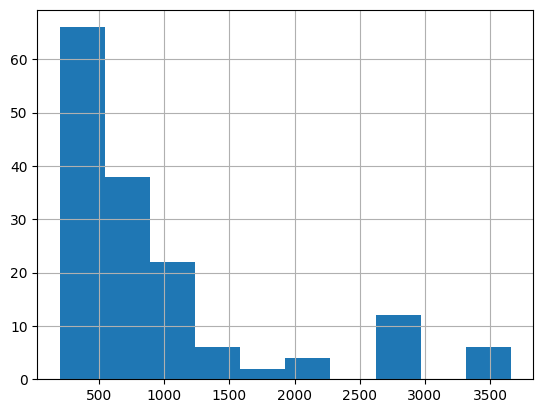

In [ ]:
active_total_paid.query("grp == 'A'").rev.hist()

<Axes: >

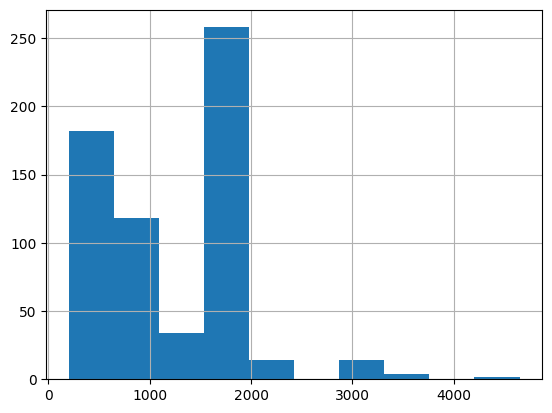

In [ ]:
active_total_paid.query("grp == 'B'").rev.hist()

Видим неравномерное распределение, посмотрим на выбросы с помощью боксплот

<Axes: xlabel='grp', ylabel='rev'>

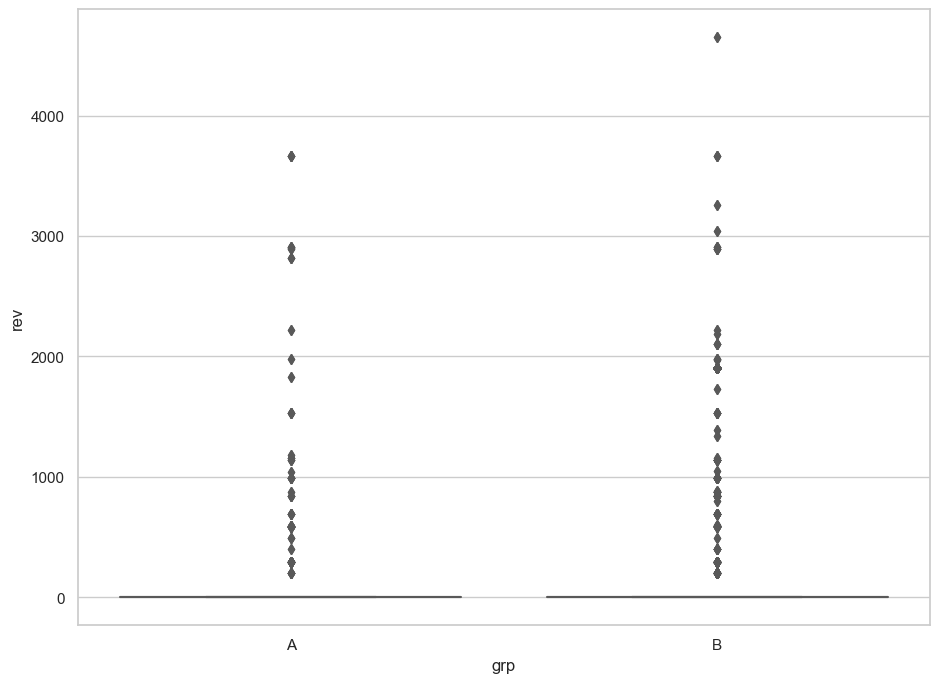

In [ ]:
sns.set(rc={'figure.figsize' : (11, 8)}, style="whitegrid", palette="Set2") #установлю размеры и стиль
sns.boxplot(data = active_total, x = 'grp', y = 'rev')

<Axes: xlabel='grp', ylabel='rev'>

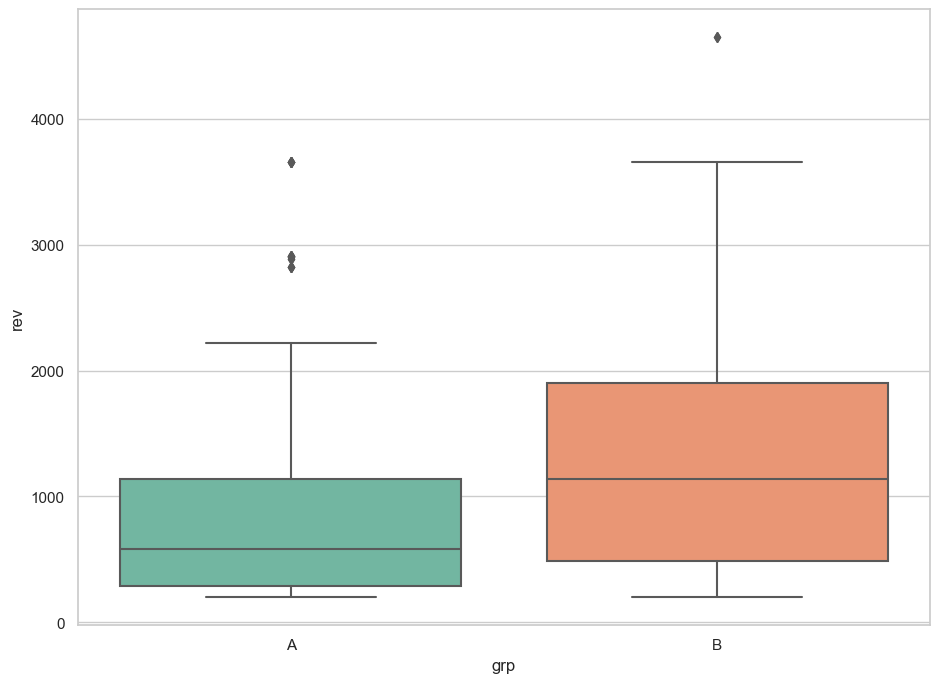

In [ ]:
sns.boxplot(data = active_total_paid, x = 'grp', y = 'rev')

Из боксплот мы видим, что в наших данных есть выбросы, распределения оплат выглядят не равномерными, не унимодальными.\

В нашем случае, где присутствует оплата и проверяется новая механика оплаты, будет неправильным удалять выбросы, так как мы можем удалить из анализа клиентов с большими суммами оплат.

Так же из-за выбросов сравнение средних в наших выборках будет некорректно. Значит, применение Т-критерия, который сравнивает средние в распределениях, а выбросы сильно влияют на значение среднего, будет неправильным.

#### Сформулирю предварительную гипотезу

* H0 - Новая механика оплаты услуг на сайте в группе B не отличается от базовой механики котрольной группы A.
* H1 - Новая механика оплаты услуг на сайте в группе B имеет значимые различия в сравнении с базовой механикой в группе A.

#### Выберу метрики

Так как у нас есть две категориальные переменные - принадлежность к группе и факт оплаты (1 или 0)-  следует проверить коэффициент конверсии в целевое действие, а конкретно в оплату услуги на сайте (CR). Также проверим степень воздействия новой механики оплаты на среднее значение суммы оплаты (ARPPU). Ещё посчитаю ARPU вместе с ARPPU для просмотра степени воздействия на всех активных пользователей. \
Таким образом:

* CR в оплату (сonversion rate) — отношение количества платящих пользователей к общему количеству пользователей.\
Переход в оплату услуги. CR будет выше в том варианте, где пользователю проще проивзести оплату.

* ARPU - отношение всей выручки на количество активных пользователей.

* ARPPU - отношение выручки на количество активных оплативших пользователей.

In [ ]:
metrics = pd.DataFrame()
metrics['students'] = active_total.groupby("grp").id.count()
metrics['paying_students'] = active_total.query("payment == 1").groupby("grp").id.count()
metrics['repeat_purchases'] = active_total.groupby('grp').rev.count() / active_total.query('rev.notna()')\
                                          .groupby('grp').rev.count()
metrics['average_check'] = active_total.query("payment == 1").groupby('grp').rev.mean().round(2)
metrics['CR'] = (active_total.query("payment == 1").groupby('grp')['payment'].count() / \
                 active_total.groupby('grp')['payment'].count()).mul(100).round(2)
metrics['ARPPU'] = (active_total.groupby("grp").rev.sum() / \
                   active_total.query("payment == 1").groupby("grp").payment.count()).round(2)
metrics['ARPU'] = round(metrics['CR'] * metrics['ARPPU'], 2)

metrics.reset_index(inplace = True)
metrics

,grp,students,paying_students,repeat_purchases,average_check,CR,ARPPU,ARPU
0,A,3070,156,1.0,933.59,5.08,933.59,4742.64
1,B,13586,626,1.0,1255.83,4.61,1255.83,5789.38


#### Имеются ли различия в показателях и с чем они могут быть связаны?
* Опять же видим, как пользователи распределены по группам неравномерно. Группа B значительно больше, чем группа А.
* Наблюдаем небольшой отрицательный эффект CR (конверсия в покупку у группы А больше, чем у группы В), и положительные эффекты в ARPU и ARPPU. То есть, конверсия падает, но доход на пользователя/покупателя растёт. Такое может происходить, если пользователь попадает на сайт и начинает осуществлять ряд целевых действий. Конечный этап заключается в оплате услуги. До момента перехода пользователя на этап оплаты, новая механика оплаты не оказывает на него влияния, либо как в нашем случае конверсия перехода в оплату упал на 0.45 пунктов. Но когда пользователь совершил целевое действие и перешел на следующий этап (хочет оплатить услугу), то новая механика начинает работать. Причем в данном случае положительно, так как средний чек увеличился. Но этого не додостаточно, и отрицательные и положительные различия в показателях требуют статистических подтверждений.
* ARPPU ожидаемо равна среднему чеку, так как на каждого совершившего оплату пользователя приходится по одной покупке (повторных покупок не было).

#### Являются ли эти различия статистически значимыми?
Для проверки стат значимости различий я выберу bootstrap, так как нет объективных причин НЕ использовать его. Объем данных ползволяет, размеры групп очень сильно отличаются, поэтому классические тесты могут давать большие погрешности. В таких случаях идеально подходит bootstrap. Гавным критерием будет, чтобы доверительный интервал не включал в себя 0

* Строим bootstrap распределения для групп А и B.
* Вычислим их разницу.
* В получившемся рапределении разницы находим доверительных интервал.
* Проверяем, попадает ли доверительный интервал в 0. Если да, то нулевая гипотеза на данном уровне значимости принимается, если нет - отвергается.

Напишем функцию, которая позволит проверять гипотезы с помощью bootstrap:

In [ ]:
# функция для проверки гипотез с помощью бутстрапа
def get_bootstrap(
    data_column_1,                       # числовые значения первой (контрольной) выборки
    data_column_2,                       # числовые значения второй (тестовой) выборки
    boot_it   = 1000,                    # количество бутстрэп-подвыборок
    statistic = np.mean,                 # интересующая нас статистика
    bootstrap_conf_level = 0.95,         # уровень значимости
    graph         = True,                # отрисовывать ли график
    show_progress = True                 # показывать ли индикатор програсса
    ):
    boot_len  = max([len(data_column_1), len(data_column_2)])
    boot_data = []

    # выбираем отрисовывать индикатора програсса или нет
    if show_progress:
        progress_bar = tqdm
    else:
        progress_bar = lambda x: x

    for i in progress_bar(range(boot_it)):        # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace = True                        # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
        ).values

        samples_delta = samples_2 - samples_1      # находим разницу подвыборок
        boot_data.append(statistic(samples_delta)) # применяем статистику для разниц подвыборок

    pd_boot_data = pd.DataFrame(boot_data)

    # доверительный интервал
    left_quant  = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x     = 0,
        loc   = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x     = 0,
        loc   = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # отисовка графиков
    if graph == True:
        plt.hist(pd_boot_data[0], bins = 50)
        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()

    return {"ci": ci,
            "p_value": p_value}

Определим функции для метрик. \
Для CR в качестве аргумента нужно будет передавать серию о факте оплаты со значениями  1 и 0, или True и False. В функции ARPPU нужно будет передавать серию, где отобраны только платежи.

In [ ]:
def cr_func(x):
    '''
    CR
    Для корректной работы функции в качестве аргумента y
    необходимо передать серию со значениями 1 и 0, или True и False,
    в соответствие с тем произошло ожидаемое событие или нет.
    '''
    return sum(x) / len(x)

def arpu_func(y):
    '''
    ARPU
    Для корректной работы функции в качестве аргумента y
    необходимо передать серию, где все NaN-значения заменнены на нули
    '''
    return np.mean(y)

def arppu_func(y):
    '''
    ARPPU
    Для корректной работы функции в качестве аргумента y
    необходимо передать серию, где отобраны только платежи, т.е. отфильтрованы нули
    или вместо нулей стоят NaN.
    '''
    return np.mean(y)

**Бутстрап по CR** \
Гипотеза:\
Н0: Конверсия в оплату в двух группах не отличается \
Н1: Конверсия в оплату в двух группах отличается

  0%|          | 0/1000 [00:00<?, ?it/s]

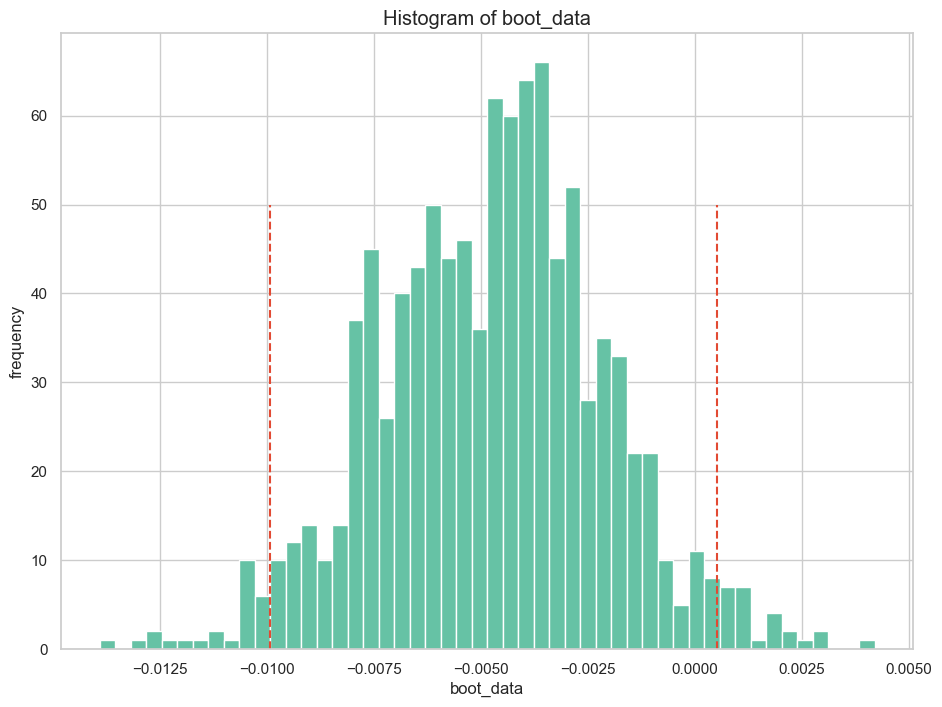

In [ ]:
cr_boot = get_bootstrap(data_column_1 = active_total.query('grp == "A"').payment,
                        data_column_2 = active_total.query('grp == "B"').payment,
                        statistic = cr_func)

Группы всё-таки не отличаются друг от друга. Это видно по доверительному интервалу, который попадает в 0. Недостаточно оснований отвергнуть нулевую гипотезу. Нельзя утверждать, что различия CR в двух группах есть.

**Бутстрап по ARPU**\
Гипотеза:\
Н0: ARPU в двух группах не отличается \
Н1: ARPU в двух группах отличается

  0%|          | 0/1000 [00:00<?, ?it/s]

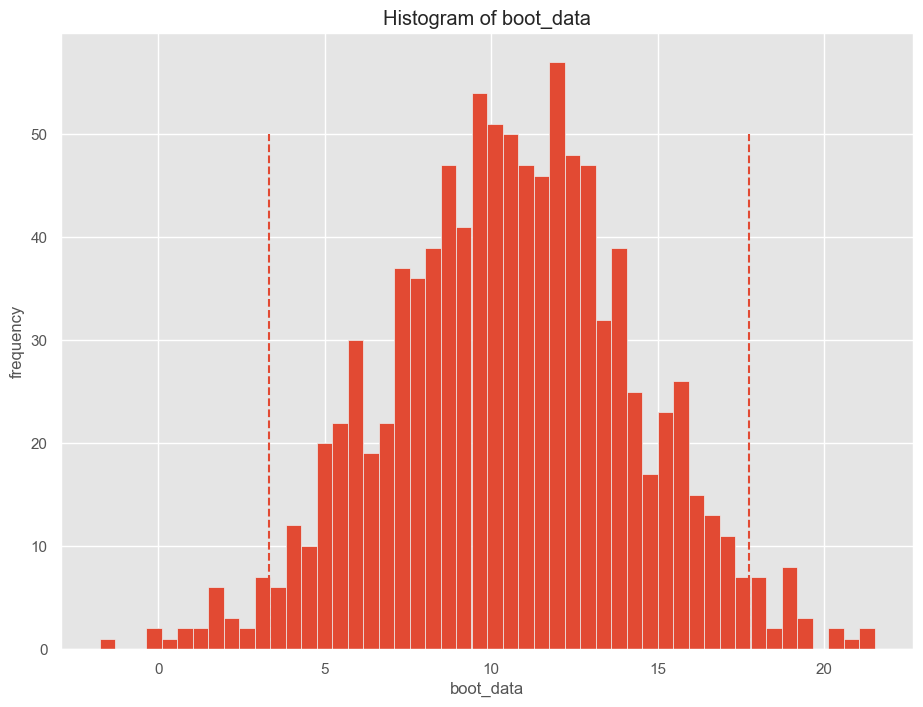

In [ ]:
arpu_boot = get_bootstrap(data_column_1 = active_total.query('grp == "A"').rev,
                        data_column_2 = active_total.query('grp == "B"').rev,
                        statistic = arpu_func)

**Вывод по бутстрапу по ARPU**:\
0 не попадает в доверительный интервал. Отвергаем нулевую гипотезу. ARPU в двух группах различаются.

**Бутстрап ARPPU**\
Гипотеза:\
Н0: ARPPU в двух группах не отличается \
Н1: ARPPU в двух группах отличается

  0%|          | 0/1000 [00:00<?, ?it/s]

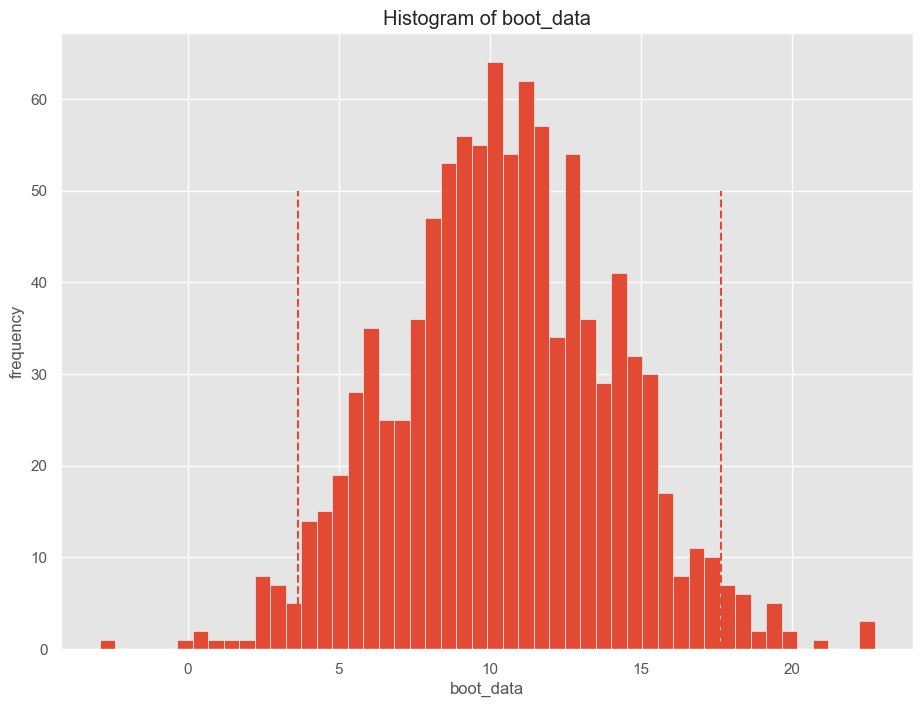

In [ ]:
arppu_boot = get_bootstrap(data_column_1 = active_total.query('grp == "A"').rev,
                        data_column_2 = active_total.query('grp == "B"').rev,
                        statistic = arppu_func)

**Вывод по бутстрапу по ARPPU**:\
Доверительный интервал не включает в себя 0. Отвергаем нулевую гипотезу. ARPPU в двух группах различаются. Очень малое количество наблюдений из двух выборок пересекаются между собой.

#### Стоит ли запускать новую механику на всех пользователей?
Напомним основные гипотезы:
* H0 - Новая механика оплаты услуг на сайте в группе B не отличается от старой механики, оставленной в группе A.
* H1 - Новая механика оплаты услуг на сайте в группе B имеет значимые различия в сравнении с механикой в группе A. \

Напомним выводы по тестам:
* Бутстрап по CR показал pvalue > 0.05. Это не дало нам основания отвергнуть нулевую гипотезу.
* Бутстрап по ARPU показал pvalue < 0.05. Есть основания отвергнуть нулевую гипотезу.
* Бутстрап по ARPPU показал pvalue < 0.05. Это дает нам основания отвергнуть нулевую гипотезу.

Таким образом, согласно проведенным тестам  новая механика оплаты даёт статистически значимый прирост в метриках ARPU и ARPPU. Имеет смысл применить новую механику оплаты услуг на всех пользователей. При этом в дальнейшем следить за метриками. Особенно за коэффициентом конверсии перехода к оплате. \
Однако стоит еще отметить, что так как система сплитования делит пользователей на группы неравномерно, в результате мы тестируем изменения на 85% наших активных пользователей. В будущем неудачный эксперимент в таком объеме может привести к значительному падению выручки.\
В идеале нужно было выделить больше пользователей для группы А, потому что из-за малого количества уникальных пользователей в группе А мы можем столкнуться с ситуацией, когда тесты показали статистически значимые различия, а в генеральной совокупности эти различий может не оказаться, либо различия будут в пользу базовой механики оплаты услуг на сайте.